In [148]:
# some help from https://www.youtube.com/watch?v=zWXTpZX4PPo
# tfp example from video https://www.tensorflow.org/probability/examples/Modeling_with_JointDistribution

In [149]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import arviz as az

In [271]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [151]:
dtype = tf.float32

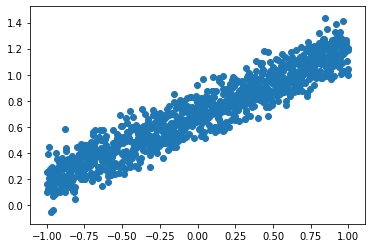

In [152]:
a_true = 0.5
b_true = 0.7
noise_true = 0.1
x_data = np.linspace(-1, 1, 1000)

noise = stats.norm(0, noise_true).rvs(size=len(x_data))

y_data = a_true * x_data + b_true + noise

x_data = tf.convert_to_tensor(x_data, dtype)
y_data = tf.convert_to_tensor(y_data, dtype)

plt.figure()
plt.scatter(x_data, y_data)

In [153]:
def joint_log_prob(x_data, y_data, a, b, sigma):
    rv_a = tfd.Uniform(-30, 30)
    rv_b = tfd.Uniform(-30, 30)
    rv_sigma = tfd.HalfNormal(10)
    y_mu = x_data * a + b

    rv_y = tfd.Normal(loc=y_mu, scale=sigma)
    
    return tf.reduce_sum(rv_a.log_prob(a) + rv_b.log_prob(b) + rv_sigma.log_prob(sigma) + rv_y.log_prob(y_data))

In [154]:
joint_log_prob(x_data, y_data, a_true, b_true, noise_true)

<tf.Tensor: shape=(), dtype=float32, numpy=-9847.238>

In [155]:
def target_log_prob_fn(a, b, sigma):
    return joint_log_prob(x_data, y_data, a, b, sigma)

In [156]:
target_log_prob_fn(1,1,0.1)

<tf.Tensor: shape=(), dtype=float32, numpy=-18628.797>

In [157]:
%%time
eps_conditional = 0.1
a_min, a_max = 0., 1.
b_min, b_max = 0., 1.
a_range = np.linspace(a_min, a_max, 100)
b_range = np.linspace(b_min, b_max, 100)

a_grid, b_grid = np.meshgrid(a_range, b_range)

aa, bb, ss = [tf.cast(x, dtype) for x in [a_grid.flatten(), b_grid.flatten(), np.ones(100*100)*eps_conditional]]

log_prob_flatten = []
for i in range(len(aa)):
    log_prob_flatten.append(target_log_prob_fn(aa[i], bb[i], ss[i]))


CPU times: user 12.4 s, sys: 10.6 ms, total: 12.4 s
Wall time: 12.4 s


In [158]:
log_prob_flatten = np.array(log_prob_flatten)

In [159]:
log_prob_flatten.argmax()

6950

In [160]:
log_prob_flatten.max()

-9846.36

In [161]:
log_prob_grid = np.reshape(log_prob_flatten, [100, 100])

In [162]:
log_prob_grid.shape

(100, 100)

In [163]:
log_prob_grid.argmax()

6950

In [164]:
a_grid.shape

(100, 100)

In [165]:
a_grid.flatten()[6949]

0.494949494949495

In [166]:
b_grid.flatten()[6949]

0.696969696969697

In [167]:
ss[6949]

<tf.Tensor: shape=(), dtype=float32, numpy=0.1>

In [168]:
target_log_prob_fn(0.494949494949495, 0.696969696969697, 1)

<tf.Tensor: shape=(), dtype=float32, numpy=-11646.14>

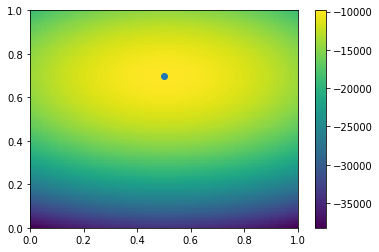

In [169]:
ax = plt.imshow(log_prob_grid, origin='lower', cmap='viridis', extent=[a_min, a_max, b_min, b_max], aspect='auto')
plt.colorbar(ax)
plt.scatter(a_true, b_true)

In [170]:
x_data.shape

TensorShape([1000])

In [171]:
a_grid.flatten().shape

(10000,)

In [172]:
x_data[tf.newaxis].shape

TensorShape([1, 1000])

In [173]:
a_grid.flatten()[:,tf.newaxis].shape

(10000, 1)

In [174]:
a_grid.flatten()[:, tf.newaxis] * x_data[tf.newaxis]

<tf.Tensor: shape=(10000, 1000), dtype=float32, numpy=
array([[-0.        , -0.        , -0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.01010101, -0.01008079, -0.01006057, ...,  0.01006057,
         0.01008079,  0.01010101],
       [-0.02020202, -0.02016158, -0.02012113, ...,  0.02012113,
         0.02016158,  0.02020202],
       ...,
       [-0.97979796, -0.97783643, -0.97587484, ...,  0.97587484,
         0.97783643,  0.97979796],
       [-0.989899  , -0.9879172 , -0.98593545, ...,  0.98593545,
         0.9879172 ,  0.989899  ],
       [-1.        , -0.997998  , -0.995996  , ...,  0.995996  ,
         0.997998  ,  1.        ]], dtype=float32)>

In [175]:
def joint_log_prob_batch(x_data, y_data, a, b, sigma):
    rv_a = tfd.Uniform(-30, 30)
    rv_b = tfd.Uniform(-30, 30)
    rv_sigma = tfd.HalfNormal(10)
    y_mu = x_data[tf.newaxis] * a[:, tf.newaxis] + b[:, tf.newaxis]

    rv_y = tfd.Normal(loc=y_mu, scale=sigma[:,tf.newaxis])
    
    return tf.reduce_sum(rv_a.log_prob(a[:, tf.newaxis]) + rv_b.log_prob(b[:, tf.newaxis]) + rv_sigma.log_prob(sigma[:, tf.newaxis]) + rv_y.log_prob(y_data), axis=1)

In [176]:
@tf.function(experimental_compile=True)
def joint_log_prob_batch_compiled(x_data, y_data, a, b, sigma):
    rv_a = tfd.Uniform(-30, 30)
    rv_b = tfd.Uniform(-30, 30)
    rv_sigma = tfd.HalfNormal(10)
    y_mu = x_data[tf.newaxis] * a[:, tf.newaxis] + b[:, tf.newaxis]

    rv_y = tfd.Normal(loc=y_mu, scale=sigma[:,tf.newaxis])
    
    return tf.reduce_sum(rv_a.log_prob(a[:, tf.newaxis]) + rv_b.log_prob(b[:, tf.newaxis]) + rv_sigma.log_prob(sigma[:, tf.newaxis]) + rv_y.log_prob(y_data), axis=1)

In [177]:
joint_log_prob_batch(x_data, y_data, a_grid.flatten(), b_grid.flatten(), tf.ones(10000)*0.1)

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([-38228.31 , -38060.64 , -37896.38 , ..., -18299.611, -18462.502,
       -18628.797], dtype=float32)>

In [178]:
%%timeit
joint_log_prob_batch(x_data, y_data, a_grid.flatten(), b_grid.flatten(), tf.ones(10000)*0.1)

68.2 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [179]:
%%timeit
joint_log_prob_batch_compiled(
    x_data,
    y_data,
    tf.convert_to_tensor(a_grid.flatten(), dtype),
    tf.convert_to_tensor(b_grid.flatten(), dtype),
    tf.ones(10000, dtype)*0.1)

5.64 ms ± 362 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [180]:
%%time
res = joint_log_prob_batch(x_data, y_data, a_grid.flatten(), b_grid.flatten(), tf.ones(10000)*0.1)

CPU times: user 106 ms, sys: 189 ms, total: 295 ms
Wall time: 70.1 ms


In [181]:
%%time
res_compiled = joint_log_prob_batch_compiled(
    x_data,
    y_data,
    tf.convert_to_tensor(a_grid.flatten(), dtype),
    tf.convert_to_tensor(b_grid.flatten(), dtype),
    tf.ones(10000, dtype)*0.1)

CPU times: user 18.1 ms, sys: 50.5 ms, total: 68.6 ms
Wall time: 17.5 ms


In [182]:
tf.reduce_sum(res_compiled - res)

<tf.Tensor: shape=(), dtype=float32, numpy=-7.446289>

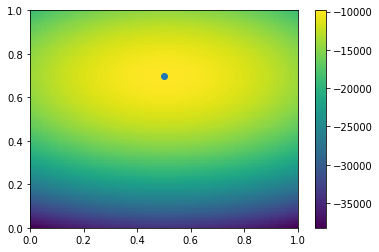

In [183]:
ax = plt.imshow(res.numpy().reshape([100, 100]), origin='lower', cmap='viridis', extent=[a_min, a_max, b_min, b_max], aspect='auto')
plt.colorbar(ax)
plt.scatter(a_true, b_true)

In [184]:
tf.reduce_sum(res-log_prob_flatten)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

# Using JointDist

In [209]:
ols_batch = tfd.JointDistributionSequential([
    # a
    tfd.Uniform(-30, 30),
    # b
    tfd.Uniform(-30, 30),
    # sigma
    tfd.HalfNormal(20),
    # likelihood
    lambda sigma, b, a: tfd.Independent(
            tfd.Normal(
                loc=x_data[tf.newaxis, ...] * a[..., tf.newaxis] + b[..., tf.newaxis],
                scale=sigma[..., tf.newaxis]
            )
        , reinterpreted_batch_ndims=1)    
])

In [232]:
ols_batch = tfd.JointDistributionSequential([
    # a
    tfd.Uniform(-30, 30),
    # b
    tfd.Uniform(-30, 30),
    # sigma
    tfd.HalfNormal(20),
    # likelihood
    lambda sigma, b, a: tfd.Independent(
            tfd.Normal(
                loc=x_data[tf.newaxis, ...] * a[..., tf.newaxis] + b[..., tf.newaxis],
                scale=sigma[..., tf.newaxis]
            )
        , reinterpreted_batch_ndims=1)    
])

In [259]:
ols_batch.sample(3)

[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([14.328869, 26.880486, 19.946514], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-13.448509, -19.604946, -12.243046], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([25.922016, 61.3534  ,  7.759664], dtype=float32)>,
 <tf.Tensor: shape=(3, 1000), dtype=float32, numpy=
 array([[-73.562775 , -78.67717  , -69.008575 , ...,  -7.8387184,
         -21.076794 ,  -6.6255317],
        [ 15.906376 , -53.692837 ,  -7.4303284, ...,  33.73317  ,
          -2.2133102,  60.372074 ],
        [-34.3078   , -39.14293  , -29.117382 , ...,  15.727226 ,
          -2.1144295,  10.154582 ]], dtype=float32)>]

In [233]:
ols_batch.log_prob_parts(ols_batch.sample(3))

[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-4.0943446, -4.0943446, -4.0943446], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-4.0943446, -4.0943446, -4.0943446], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-3.2227223, -3.9206696, -3.2671416], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1417.3925, -4584.0146, -3221.5159], dtype=float32)>]

In [234]:
ols_batch.log_prob(ols_batch.sample(3))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-4529.7227, -4091.9556, -2801.5483], dtype=float32)>

In [230]:
ols_batch.resolve_graph()

(('a', ()), ('b', ()), ('sigma', ()), ('x', ('sigma', 'b', 'a')))

In [266]:
aa, bb, ss, _ll = ols_batch.sample(1000)

In [267]:
ll = ols_batch.log_prob(aa, bb, ss, _ll)

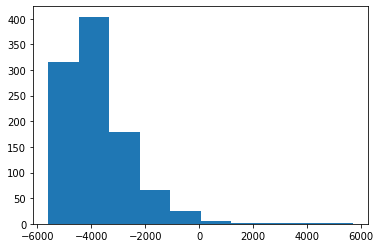

In [268]:
plt.figure()
# plt.hist(aa.numpy());
# plt.hist(bb.numpy());
# plt.hist(ss.numpy());
plt.hist(ll.numpy());

## sampling

In [294]:
def gen_ols_batch_model(X, hyperprior_mean=0, hyperprior_scale=1):
    hyper_mean = tf.cast(hyperprior_mean, dtype)
    hyper_scale = tf.cast(hyperprior_scale, dtype)
    return tfd.JointDistributionSequential([
      # b0
      tfd.Sample(tfd.Normal(loc=hyper_mean, scale=hyper_scale), sample_shape=1),
      # b1
      tfd.Sample(tfd.Normal(loc=hyper_mean, scale=hyper_scale), sample_shape=1),
      # sigma
      tfd.Sample(tfd.HalfNormal(20), sample_shape=1),
      # likelihood
      lambda sigma, b1, b0: tfd.Independent(
          tfd.Normal(
              # Parameter transformation
              loc=b0 + b1*X,
              scale=sigma),
          reinterpreted_batch_ndims=1
      ),
    ], validate_args=True)

mdl_ols_batch = gen_ols_batch_model(x_data[tf.newaxis, ...])

In [297]:
mdl_ols_batch.sample([3,4])

[<tf.Tensor: shape=(3, 4, 1), dtype=float32, numpy=
 array([[[-2.3622415 ],
         [-0.69901544],
         [ 1.0091095 ],
         [ 0.78524256]],
 
        [[ 0.5813983 ],
         [-1.2354782 ],
         [-0.15054576],
         [ 0.26777908]],
 
        [[-0.15596448],
         [-0.5068729 ],
         [-0.6916211 ],
         [ 0.851986  ]]], dtype=float32)>,
 <tf.Tensor: shape=(3, 4, 1), dtype=float32, numpy=
 array([[[ 1.5393933 ],
         [ 0.95942044],
         [-0.74274915],
         [ 0.06337824]],
 
        [[ 1.6555519 ],
         [ 1.1624094 ],
         [-1.7008821 ],
         [ 0.6165485 ]],
 
        [[-1.3446528 ],
         [ 0.4571101 ],
         [ 1.199484  ],
         [ 2.1805632 ]]], dtype=float32)>,
 <tf.Tensor: shape=(3, 4, 1), dtype=float32, numpy=
 array([[[16.929914 ],
         [14.360525 ],
         [23.702053 ],
         [ 5.1582575]],
 
        [[17.458683 ],
         [13.565229 ],
         [ 7.6652627],
         [ 0.8269607]],
 
        [[ 7.8458767],
     

In [343]:
@tf.function(autograph=False, experimental_compile=True)
def run_chain(init_state, step_size, target_log_prob_fn, unconstraining_bijectors,
              num_steps=10000, burnin=2000):

    def trace_fn(_, pkr):
        return (
            pkr.inner_results.inner_results.target_log_prob,
            pkr.inner_results.inner_results.leapfrogs_taken,
            pkr.inner_results.inner_results.has_divergence,
            pkr.inner_results.inner_results.energy,
            pkr.inner_results.inner_results.log_accept_ratio
               )

    kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn,
      step_size=step_size),
    bijector=unconstraining_bijectors)

    hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin,
    step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
        inner_results=pkr.inner_results._replace(step_size=new_step_size)),
    step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
    log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )

    # Sampling from the chain.
    chain_state, sampler_stat = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=hmc,
      trace_fn=trace_fn)
    return chain_state, sampler_stat

In [374]:
nchain = 10
b0, b1, sigma, _ = ols_batch.sample(nchain)
init_state = [b0, b1, sigma]
step_size = [tf.cast(i, dtype=dtype) for i in [.1, .1, .1]]

In [375]:

target_log_prob_fn = lambda *x: ols_batch.log_prob(x + (y_data, ))

In [376]:


# bijector to map contrained parameters to real
unconstraining_bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity()
]


In [377]:
%%time
samples, sampler_stat = run_chain(
    init_state, step_size, target_log_prob_fn, unconstraining_bijectors)

CPU times: user 11.3 s, sys: 51.8 ms, total: 11.4 s
Wall time: 11.4 s


In [378]:
# samples

In [379]:
# using the pymc3 naming convention
sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}
sample_stats['tree_size'] = np.diff(sample_stats['tree_size'], axis=1)

var_name = ['b0', 'b1', 'sigma']
posterior = {k:np.swapaxes(v.numpy(), 1, 0) 
             for k, v in zip(var_name, samples)}

az_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)

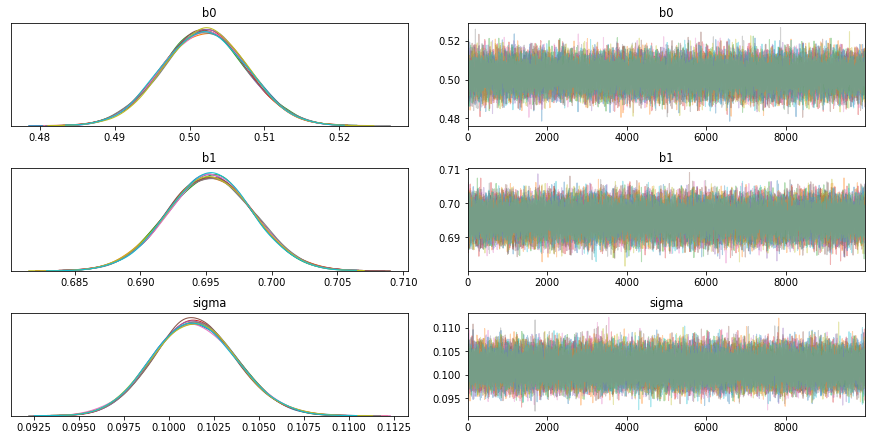

In [380]:
az.plot_trace(az_trace);


In [381]:
posterior['b0'][:,1000:].shape

(10, 9000)

In [382]:
pp

array([0.10102412, 0.10153599, 0.10040685, ..., 0.10053276, 0.10327878,
       0.1010199 ], dtype=float32)

In [383]:
a_true

0.5

In [384]:
b_true

0.7

In [385]:
noise_true

0.1

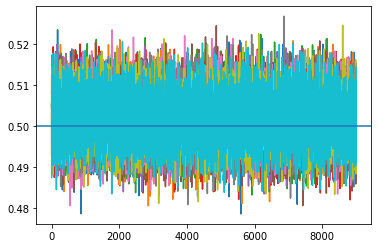

In [386]:
burnin = 1000
plt.figure()
for i in range(nchain):
    pp = posterior['b0'][i, burnin:]
    plt.plot(range(len(pp)), pp)
plt.axhline(a_true)

In [387]:
burnin = 1000
plt.figure()
for i in range(nchain):
    pp = posterior['b1'][i, burnin:]
    plt.plot(range(len(pp)), pp)
plt.axhline(b_true)

In [388]:
burnin = 1000
plt.figure()
for i in range(nchain):
    pp = posterior['sigma'][i, burnin:]
    plt.plot(range(len(pp)), pp)
plt.axhline(noise_true)

In [389]:
az.plot_forest(az_trace,
               kind='ridgeplot',
               linewidth=4,
               combined=True,
               ridgeplot_overlap=1.5,
               figsize=(9, 4));

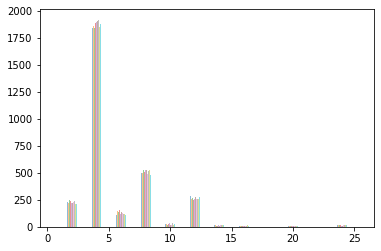

In [390]:
plt.hist(az_trace.sample_stats['tree_size'], np.linspace(.5, 25.5, 26), alpha=.5);
